# Домашнее задание №2. Оптимальные портфели инвестиций
#### Выполнили: Мельников, Малышева, Селивановская

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy
import math
import seaborn as sns
import warnings
from random import randint
warnings.filterwarnings('ignore')

from IPython.display import clear_output

## Загрузка данных, предобработка, рассчет логарифмической доходности

In [2]:
# todo: turn the code below into a function 
# done

def download_data(tickers_list, local_file=False, reduce_tickers=False, add_index=False):   
        
    if not local_file:
        data = yf.download(tickers_list,'2019-01-02','2019-12-31') # ! 
    else:
        data = pd.read_pickle('ticker_data')
    
    data = data.drop(columns = ['Low', 'High', 'Open', 'Close'])
    
    index = pd.read_csv('index_ixic.csv', sep=",")
    index = index.drop(columns = ['Low', 'High', 'Open', 'Close'])
    
    adj_close = data['Adj Close'] # adjusted closing price
    volume = data['Volume'] # sales volume

    adj_close.reset_index(level=0, inplace=True) # set index from date to int
    volume.reset_index(level=0, inplace=True)

    for i in range(0, len(adj_close['Date'])):
        volume.loc[i, 'Date'] = str(volume['Date'][i].date())
        adj_close.loc[i, 'Date'] = str(adj_close['Date'][i].date())


    adj_indexes = set(adj_close['Date'].to_list())
    ind_indexes = set(index['Date'].to_list())
    diff = adj_indexes.difference(ind_indexes)

    adj_close = adj_close.loc[adj_close['Date'] != '2019-11-28']
    volume = volume.loc[volume['Date'] != '2019-11-28']

    #handling missing values
    adj_close = adj_close.dropna(axis=1, how='any')
    volume = volume.dropna(axis=1, how='any')

    #add the index data to the main data
    if add_index:
        adj_close['IXIC'] = index['Adj Close']
        volume['IXIC'] = index['Volume']

    #delete last day as ixic is nan
    adj_close = adj_close.loc[adj_close['Date'] != '2019-12-30']
    volume = volume.loc[volume['Date'] != '2019-12-30']

    #reindex after drop
    adj_close.reset_index(drop=True, inplace=True)

    #reduce the number of tickers
    
    if reduce_tickers is True:
        tickers_to_delete = adj_close.columns.to_list()
        tickers_to_delete.remove('Date')
        tickers_to_delete.remove('IXIC')
        tickers_to_delete = tickers_to_delete[::2]
        adj_close.drop(tickers_to_delete, inplace=True, axis=1) 
        volume.drop(tickers_to_delete, inplace=True, axis=1) 

    # calculate logarithmic returns
    log_returns = pd.DataFrame(index = adj_close.index, columns = adj_close.columns)
    log_returns['Date'] = adj_close['Date']
    tickers = adj_close.columns.to_list()
    tickers.remove('Date')

    #num_days=len(log_returns['AADR'])
    num_days=len(log_returns[tickers[0]])
    print(len(tickers))
    
    
    for ticker in tickers:
        for i in range(1, num_days):
            log_returns.loc[i, ticker] = np.log(adj_close.loc[i, ticker]/adj_close.loc[i-1, ticker])
    #dropping first day
    log_returns = log_returns.dropna(axis=0, how='any')
    log_returns.reset_index( drop=True, inplace=True) 
    
    if add_index:
        
        index_log_returns = log_returns.loc[:, ["Date", "IXIC"]]
        log_returns.drop(columns=['IXIC'], axis=0, inplace=True)
        
        return log_returns, index_log_returns
    
    return log_returns

## 1.Efficient frontier. 

Выбрать на рынке набор из 50 акций. Объясните ваш выбор. Построить эффективный фронт портфелей инвестиций без ограничений на короткие позиции и эффективный фронт с запретом коротких позиций. Сравнить эффективные фронты и сделать выводы. При построении эффективных фронтов вычислить портфели с минимальным риском и отметить их на соответствующем эффективном фронте. Рассмотреть портфель с равными долями вложения капитала и оценить, как далек этот портфель от эффективного фронта. Тот же вопрос для индекса рынка.

### Выберем первые 50 акций по алфавиту из списка компаний, формирующих индекс Nasdaq-100.

Этот индекс включает в себя 100 крупнейших по капитализации компаний, акции которых торгуются на бирже NASDAQ. 

In [8]:
nasdaq_100_tickers = list(pd.read_csv("nasdaq-100_tickers.csv", header=None)[0])
log_returns50, index_log_returns = download_data(nasdaq_100_tickers, local_file=False, reduce_tickers=False, add_index=True)
log_returns50 = log_returns50.iloc[:, 0:51] # отбираем 50 компаний
tickers50 = log_returns50.columns[1::]

[*********************100%***********************]  103 of 103 completed
99


In [9]:
log_returns50

,Date,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,...,GILD,GOOG,GOOGL,HON,IDXX,ILMN,INCY,INTC,INTU,ISRG
0,2019-01-03,-0.104924,-0.040299,-0.062306,-0.030664,-0.056712,-0.002333,-0.089696,-0.059692,-0.099301,...,0.028131,-0.028898,-0.028086,-0.01344,-0.024635,-0.035528,0.068405,-0.056584,-0.031074,-0.034469
1,2019-01-04,0.041803,0.047487,0.023988,0.039081,0.051425,0.009165,0.010391,0.066241,0.108289,...,0.044951,0.05239,0.050021,0.034383,0.051509,0.06289,0.060019,0.059553,0.03891,0.04652
2,2019-01-07,-0.002228,0.013481,0.006269,-0.005425,0.034026,-0.005598,0.017046,0.017647,0.079395,...,0.004532,-0.002169,-0.001996,0.005556,-0.002885,0.017033,0.02649,0.004648,0.01514,0.01423
3,2019-01-08,0.018884,0.014807,0.024103,0.005882,0.008627,0.012248,0.015828,-0.041369,0.008713,...,-0.006879,0.007358,0.008745,-0.00207,0.01276,-0.047014,0.009255,0.006304,0.023688,0.009465
4,2019-01-09,0.016839,0.01175,0.025025,0.000913,0.021432,-0.007603,0.037485,0.041369,-0.027359,...,-0.002205,-0.001506,-0.003433,0.004653,0.01536,0.038369,-0.016151,0.005639,-0.003104,0.06826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2019-12-20,-0.002073,-0.000061,0.009391,0.013831,-0.005128,0.009848,-0.003146,0.018616,0.030354,...,0.023612,-0.004768,-0.003856,-0.00051,0.020706,0.015076,-0.011477,0.016936,0.011485,0.004407
245,2019-12-23,0.016187,0.004082,-0.00544,-0.006274,0.000437,-0.012192,0.019056,-0.011881,0.02924,...,-0.001497,-0.000556,-0.000437,0.000113,0.009248,0.011684,0.000666,0.004739,-0.003075,0.01028
246,2019-12-24,0.00095,0.002095,0.004605,-0.000647,0.005398,0.000959,-0.000899,0.006853,0.023479,...,-0.00045,-0.003922,-0.004601,-0.000681,-0.002731,0.004391,0.013988,0.003034,-0.00735,0.002324
247,2019-12-26,0.019646,0.004721,0.000084,0.002586,0.001793,0.000426,0.001331,-0.003094,0.001932,...,-0.004958,0.012456,0.013329,0.003228,-0.006976,-0.012447,-0.0293,0.006878,0.009563,-0.001287


In [10]:
# for testing purposes
'''
tickers50 = []
for i in range(5):
    tickers50.append(tickers[randint(0, len(tickers))])
tickers50

x = np.random.random(5)
x = x/np.sum(x) # нормализация
x = np.array(x)

log_returns50 = log_returns[tickers50]
'''

'\ntickers50 = []\nfor i in range(5):\n    tickers50.append(tickers[randint(0, len(tickers))])\ntickers50\n\nx = np.random.random(5)\nx = x/np.sum(x) # нормализация\nx = np.array(x)\n\nlog_returns50 = log_returns[tickers50]\n'

In [11]:
# выборочные средние 
def calc_sample_means(returns):
    tickers = returns.columns[1:] # предполагаем, что первый столбец - дата 
    sample_means = pd.DataFrame(columns = ['Sample mean (E)'], index = tickers)
    for ticker in tickers:
        mean = np.mean(returns[ticker])
        sample_means['Sample mean (E)'][ticker] = mean
    return sample_means

'''
sample_means50 = pd.DataFrame(columns = ['Sample mean (E)'], index = tickers50) # sample means (E) for each of the 50 stocks

for ticker in tickers50:
    mean = np.mean(log_returns50[ticker])
    sample_means50['Sample mean (E)'][ticker] = mean
'''

"\nsample_means50 = pd.DataFrame(columns = ['Sample mean (E)'], index = tickers50) # sample means (E) for each of the 50 stocks\n\nfor ticker in tickers50:\n    mean = np.mean(log_returns50[ticker])\n    sample_means50['Sample mean (E)'][ticker] = mean\n"

In [12]:
# матрица выборочных ковариаций для 50 активов
def calc_sample_cov(returns, sample_means, verbose=True):
    tickers = returns.columns[1:]
    sample_cov = pd.DataFrame(columns = tickers, index = tickers)
    
    status_count = 0
    for ticker1 in tickers:
    
        if verbose:
            status_count += 1
            clear_output()
            print(f"{status_count}/{len(tickers)}")

        for ticker2 in tickers:
            sum_ = 0
            N = returns[ticker2].shape[0] # количество наблюдений
            for i in range(N):
                sum_ += (returns[ticker1][i] - float(sample_means.loc[ticker1])) * (returns[ticker2][i] - float(sample_means.loc[ticker2]))

            sample_cov[ticker1][ticker2] = sum_ / (N)
    return sample_cov
    
'''
sample_cov50 = pd.DataFrame(columns = tickers50, index = tickers50) # sample covariance for 50 stocks

status_count = 0
for ticker1 in tickers50:
    status_count += 1
    clear_output()
    print(f"{status_count}/{len(tickers50)}")
    for ticker2 in tickers50:
        sum_ = 0
        N = log_returns50[ticker2].shape[0] # количество наблюдений
        for i in range(N):
            sum_ += (log_returns50[ticker1][i] - float(sample_means50.loc[ticker1])) * (log_returns50[ticker2][i] - float(sample_means50.loc[ticker2]))
        
        sample_cov50[ticker1][ticker2] = sum_ / (N)

'''

'\nsample_cov50 = pd.DataFrame(columns = tickers50, index = tickers50) # sample covariance for 50 stocks\n\nstatus_count = 0\nfor ticker1 in tickers50:\n    status_count += 1\n    clear_output()\n    print(f"{status_count}/{len(tickers50)}")\n    for ticker2 in tickers50:\n        sum_ = 0\n        N = log_returns50[ticker2].shape[0] # количество наблюдений\n        for i in range(N):\n            sum_ += (log_returns50[ticker1][i] - float(sample_means50.loc[ticker1])) * (log_returns50[ticker2][i] - float(sample_means50.loc[ticker2]))\n        \n        sample_cov50[ticker1][ticker2] = sum_ / (N)\n\n'

In [13]:
sample_means50 = calc_sample_means(log_returns50)
sample_cov50 = calc_sample_cov(log_returns50, sample_means50, verbose=True)
#sample_std_devs50 = calc_sample_std_devs(...)

50/50


In [14]:
# Выборочное стандартное отклонение для 50 активов
sample_std_devs50 = pd.DataFrame(data= pd.DataFrame(np.diag(sample_cov50)**0.5,
                                columns = ['Sample standard deviation (σ)'],
                                index = tickers50)) # # sample standard deviation (σ) for each of the 50 stocks

### Изобразим выбранные акции на графике

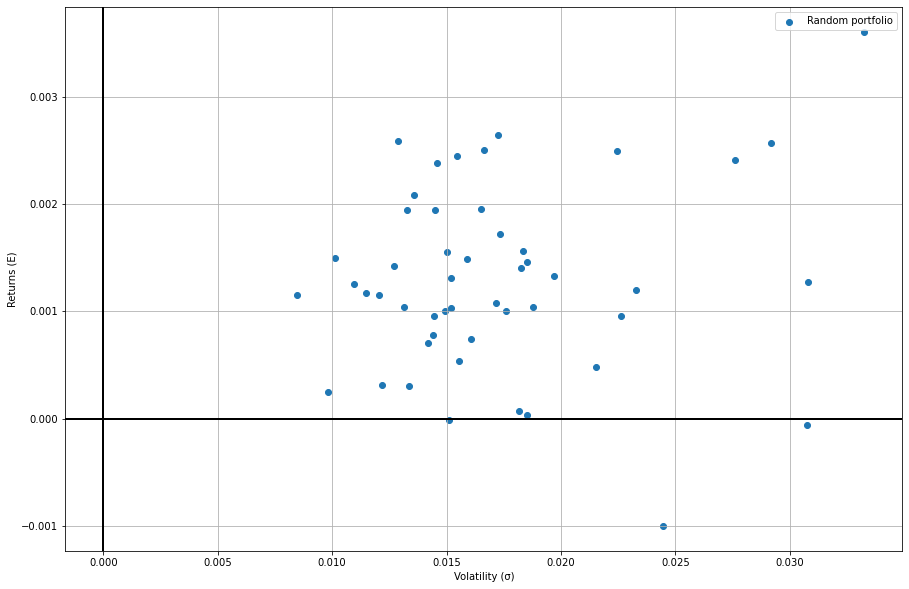

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle("")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

# random portfolios plot
ax.scatter(sample_std_devs50, sample_means50, marker="o", label="Random portfolio")
   
ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()



### Сгенерируем несколько случайных портфелей и изобразим их на графике

In [16]:
def calc_portfolio_return(x, means): # доходность портфеля, принимает np.array
    #E = sum(means.iloc[0:n_stocks] * x)
    E = np.matmul(x, means)
    E = float(E)
    return E

def calc_portfolio_volatility(x, cov_matrix): # риск портфеля, хотим найти такой вектор весов x, что риск стремится к минимуму
    sigma_sq = np.matmul(np.matmul(x, cov_matrix), x.T)
    sigma_sq = float(sigma_sq)
    return sigma_sq

def generate_random_portfolios(means, cov_matrix, short_sales=False, n_portfolios=10000):
      
    n_stocks = means.shape[0]
    
    portfolio_means = [] # returns per portfolio
    portfolio_std_devs = [] # standard deviations per portfolio
    
    x_range = () # область значений веса акции в портфеле
    if short_sales:
        x_range = (-1, 1)
    else:
        x_range = (0, 1)
        
    for portfolio in range(n_portfolios):
        x = np.random.uniform(x_range[0], x_range[1],n_stocks)
        x = x/sum(x) # нормализация
        #x = x/abs(sum(x)) # weird
        x = np.array(x)
        #print(x, x.sum())
        #portfolio_sample_means.append(sum(sample_means.iloc[0:n_stocks] * x)) # R - доходность       
        #portfolio_std_devs.append(np.matmul(np.matmul(x, covariance_matrix.iloc[0:n_stocks, 0:n_stocks]), x.T)) # риски    
        portfolio_means.append(calc_portfolio_return(x, means))
        portfolio_std_devs.append(calc_portfolio_volatility(x, cov_matrix))
        
    return portfolio_std_devs, portfolio_means


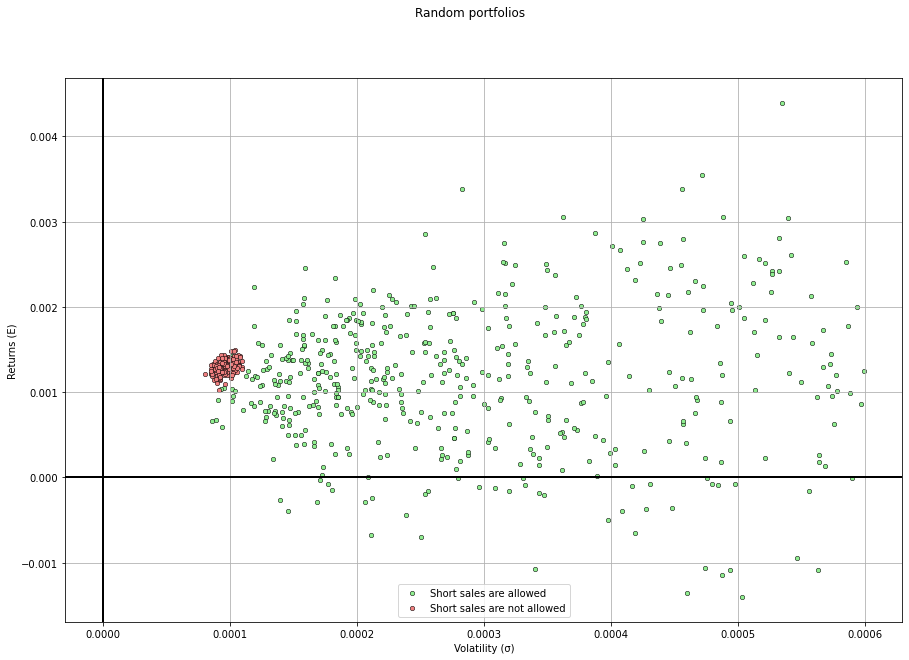

In [17]:
random_portfolios_short_std_devs, random_portfolios_short_means = generate_random_portfolios(sample_means50, sample_cov50, short_sales=True, n_portfolios=1000)
random_portfolios_no_short_std_devs, random_portfolios_no_short_means = generate_random_portfolios(sample_means50, sample_cov50, short_sales=False, n_portfolios=200)

# удаление слишком больших значений 
indices = [ind for ind in range(len(random_portfolios_short_std_devs)) if random_portfolios_short_std_devs[ind] < 0.0006]
indices = [ind for ind in indices if random_portfolios_short_means[ind] < 0.01]
random_portfolios_short_std_devs = [random_portfolios_short_std_devs[i] for i in indices]
random_portfolios_short_means = [random_portfolios_short_means[i] for i in indices]

fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle("Random portfolios")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

# random portfolios plot
ax.scatter(random_portfolios_short_std_devs, random_portfolios_short_means, marker="o", color='lightgreen',
           edgecolors= 'black', linewidth=0.5, s=20, label="Short sales are allowed")
ax.scatter(random_portfolios_no_short_std_devs, random_portfolios_no_short_means, marker="o", color='lightcoral',
           edgecolors= 'black', linewidth=0.5, s=20, label="Short sales are not allowed")

ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()


### Найдем фронты эффективных портфелей

In [18]:
def optimize_portfolio_volatility(means, cov_matrix, short_sales=True, custom_return=False, target_return=None): # x - weights of a portfolio
    n_stocks = means.shape[0]
    
    # Генерация случайного начального решения 
    x_initial = np.random.random(n_stocks)
    #x_initial = np.ones(n_stocks)
    x_initial = x_initial/np.sum(x_initial) # нормализация
    x_initial = np.array(x_initial)
    
    #print(f"X initial for {n_stocks}: {x_initial}")
    
    # Ограничения 
    
    constraints = [{'type': 'eq',
                    'fun': lambda x: x.sum() - 1.0
                   }]
    
    # если хотим найти наименьшее значение риска портфеля при заданном уровне доходности
    if custom_return:
        if target_return is None:
            print("Target Return is not set!")
            return 
        else:
            constraints.append({'type': 'eq', 
                                'fun': lambda x: calc_portfolio_return(x, means) - target_return
                               })
            print(f"Looking for a solution for {target_return}")
            
    # Ограничения на область значений x
    x_bounds = []
    if short_sales:
        # шорты разрешены, x принимает любое значение
        for i in range(n_stocks):
            x_bounds.append((None, None))
    else:
        # шорты запрещены, x принимает значение от 0 до 1
        for i in range(n_stocks):
            x_bounds.append((0, 1))        
  
    result = scipy.optimize.minimize(calc_portfolio_volatility, # функция, которую хотим оптимизировать
                                     x_initial, # начальное решение 
                                     args=(cov_matrix), # дополнительные аргументы целевой функции
                                     method='SLSQP', # метод оптимизации (МНК)
                                     constraints=constraints, # ограничения 
                                     bounds=x_bounds, # ограничения на значения x
                                     options={'maxiter':1000, 'disp': False},
                                     tol=1e-15 # tolerance? somehow fixes the issue lol 1e-15
                                    )
    
    if result.success:
        return result.x
    else:
        print("Couldn't find minimum")
        return

In [19]:
# Пример с пары 


means = pd.DataFrame(data=np.array([0.8, 0.4]))
cov = pd.DataFrame(data=np.array([[0.04, 0],
                [0, 0.04]]))

ans = optimize_portfolio_volatility(means, cov, short_sales=True)
print(ans, sum(ans))
print(calc_portfolio_volatility(ans, cov))

[0.5 0.5] 0.9999999999999999
0.019999999999999997


#### Оптимальный портфель с разрешенными короткими продажами

In [20]:
x_opt_short = optimize_portfolio_volatility(sample_means50, sample_cov50, short_sales=True)

opt_short_return = calc_portfolio_return(x_opt_short, sample_means50)
opt_short_volatility = calc_portfolio_volatility(x_opt_short, sample_cov50)
print(f"Pareto optimal Portfolio (short sales are allowed)\n {x_opt_short} ")
print(f"Portfolio's Volatility: {opt_short_volatility}, Return: {opt_short_return}")

Pareto optimal Portfolio (short sales are allowed)
 [-0.03393012  0.00301687 -0.01402588  0.02796048  0.01579302  0.37462494
 -0.01321645 -0.00466746 -0.03301092  0.0320326   0.03764007 -0.07010183
  0.01871935 -0.00700621  0.04680307  0.02108265 -0.00765095  0.00822468
 -0.00692665 -0.13319743  0.01367235  0.0287312   0.0850719   0.08164593
 -0.03187932  0.11605958  0.06839358 -0.00635689  0.0486032   0.09228598
  0.08224733  0.03337001 -0.01455786  0.04597854 -0.00053301  0.06532918
  0.05166876 -0.03270149 -0.00046493 -0.0406518   0.03235837  0.34745202
 -0.32143216  0.08280502 -0.05379749  0.00446108  0.00536186  0.0242593
 -0.00319186 -0.06635222] 
Portfolio's Volatility: 2.6699734386482263e-05, Return: 0.0008097891548979456


#### Эффективный фронт с разрешенными короткими продажами

Looking for a solution for 0.0008097891548979456
Looking for a solution for 0.0011642570265759516
Looking for a solution for 0.0015187248982539577
Looking for a solution for 0.0018731927699319638
Looking for a solution for 0.00222766064160997
Looking for a solution for 0.002582128513287976
Looking for a solution for 0.002936596384965982
Looking for a solution for 0.003291064256643988
Looking for a solution for 0.003645532128321994
Looking for a solution for 0.004


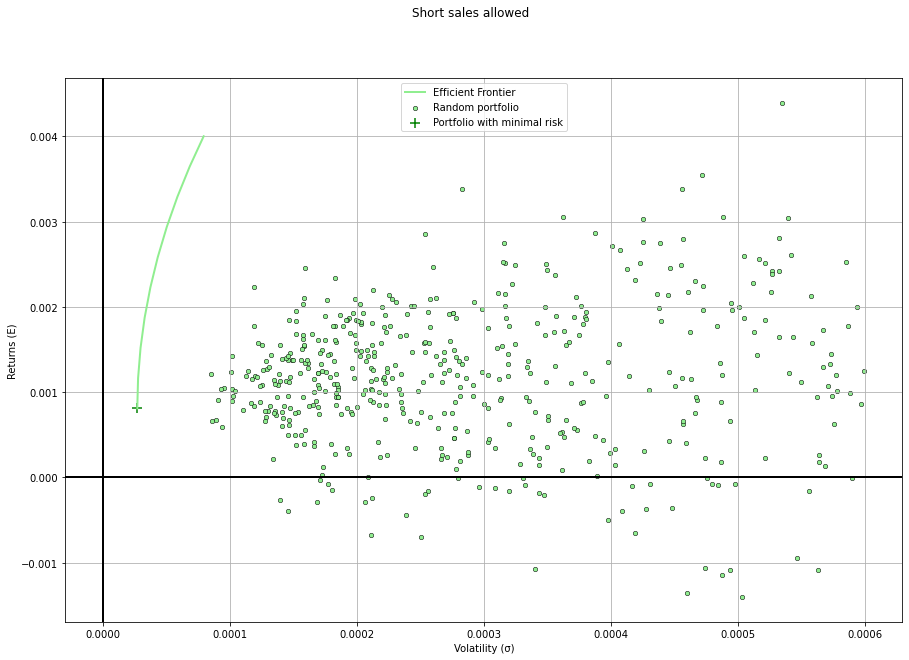

In [21]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle("Short sales allowed")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')


# random portfolios plot
#ax.scatter(random_portfolios_short_std_devs, random_portfolios_short_means, marker="g", s=2, label="Random portfolio")
ax.scatter(random_portfolios_short_std_devs, random_portfolios_short_means, marker="o", color='lightgreen',
           edgecolors= 'black', linewidth=0.5, s=20, label="Random portfolio")

# optimal frontier plot
target_returns_short = np.linspace(opt_short_return, 0.004, 10)
opt_volatilities_short = []

for target_return in target_returns_short:
    x_opt = optimize_portfolio_volatility(sample_means50, sample_cov50, short_sales=True, custom_return=True, target_return=target_return)
    #opt_return = calc_portfolio_return(x_opt, sample_means50)
    opt_volatility = calc_portfolio_volatility(x_opt, sample_cov50)
    opt_volatilities_short.append(opt_volatility)

# min risk plot 
ax.scatter(opt_short_volatility, opt_short_return, color="g", marker="+", s=100, label="Portfolio with minimal risk")    
    
ax.plot(opt_volatilities_short, target_returns_short, color="lightgreen", linewidth=2, label="Efficient Frontier")      
ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()



#### Оптимальный портфель с запрещенными короткими продажами

In [22]:
x_opt_no_short = optimize_portfolio_volatility(sample_means50, sample_cov50, short_sales=False)

opt_no_short_return = calc_portfolio_return(x_opt_no_short, sample_means50)
opt_no_short_volatility = calc_portfolio_volatility(x_opt_no_short, sample_cov50)
print(f"Pareto optimal Portfolio (short sales are NOT allowed)\n {x_opt_no_short} ")
print(f"Portfolio's Volatility: {opt_no_short_volatility}, Return: {opt_no_short_return}")

Pareto optimal Portfolio (short sales are NOT allowed)
 [1.00138846e-18 0.00000000e+00 0.00000000e+00 1.02040584e-18
 1.55745832e-18 4.03173520e-01 0.00000000e+00 2.71276699e-19
 0.00000000e+00 4.29863756e-02 0.00000000e+00 2.59955098e-19
 0.00000000e+00 0.00000000e+00 1.14773219e-18 1.35806692e-02
 2.19133591e-02 1.72490654e-18 0.00000000e+00 1.04868548e-18
 0.00000000e+00 0.00000000e+00 4.98111616e-02 4.78717703e-02
 1.20645173e-02 1.16316360e-01 2.76634689e-02 7.54682693e-19
 4.58867710e-02 8.37276724e-03 5.15241201e-02 4.68308249e-02
 2.05774387e-18 1.18836119e-02 5.73229925e-19 4.32335630e-02
 5.32439279e-02 2.62777087e-19 0.00000000e+00 2.16746036e-18
 3.64321182e-03 0.00000000e+00 0.00000000e+00 5.41006011e-19
 2.96780701e-19 5.58641722e-19 0.00000000e+00 2.61615068e-18
 1.59881022e-19 7.92962364e-19] 
Portfolio's Volatility: 3.396047472842106e-05, Return: 0.0010070223017543496


#### Эффективный фронт с разрешенными короткими продажами

Looking for a solution for 0.0010070223017543496
Looking for a solution for 0.0012284642682260886
Looking for a solution for 0.0014499062346978275
Looking for a solution for 0.0016713482011695663
Looking for a solution for 0.0018927901676413054
Looking for a solution for 0.002114232134113044
Looking for a solution for 0.002335674100584783
Looking for a solution for 0.002557116067056522
Looking for a solution for 0.0027785580335282613
Looking for a solution for 0.003


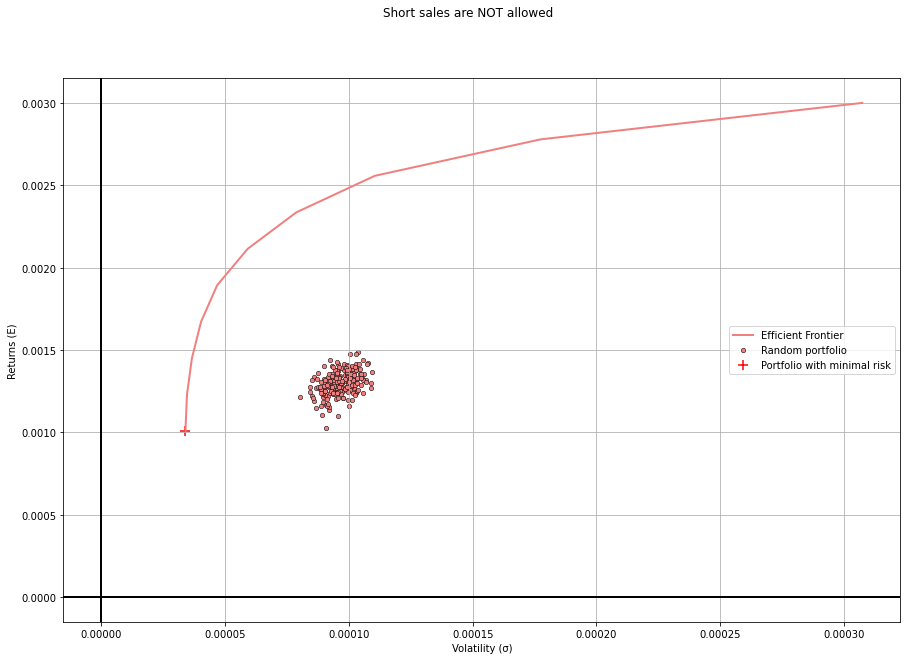

In [23]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle("Short sales are NOT allowed")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

# random portfolios plot
ax.scatter(random_portfolios_no_short_std_devs, random_portfolios_no_short_means, marker="o", color='lightcoral',
           edgecolors= 'black', linewidth=0.5, s=20, label="Random portfolio")

# optimal frontier plot
target_returns_no_short = np.linspace(opt_no_short_return, 0.003, 10)
opt_volatilities_no_short = []

for target_return in target_returns_no_short:
    x_opt = optimize_portfolio_volatility(sample_means50, sample_cov50, short_sales=False, custom_return=True, target_return=target_return)
    #opt_return = calc_portfolio_return(x_opt, sample_means50)
    opt_volatility = calc_portfolio_volatility(x_opt, sample_cov50)
    opt_volatilities_no_short.append(opt_volatility)

# min risk plot 
ax.scatter(opt_no_short_volatility, opt_no_short_return, color="r", marker="+", s=100, label="Portfolio with minimal risk")  
    
ax.plot(opt_volatilities_no_short, target_returns_no_short, color="lightcoral", linewidth=2, label="Efficient Frontier")      
ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()



### Изобразим на одном графике эффективные фронты, и оптимальные портфели

In [24]:
# рассчитаем доходность и риск портфеля с равными долями и индекса рынка

# генерация портфеля с равными долями
n_stocks = sample_means50.shape[0]
x_eq_w = np.ones(n_stocks) # x equally weighted, i. e. equally weighted portfolio 
x_eq_w = x_eq_w/np.sum(x_eq_w) # нормализация
x_eq_w = np.array(x_eq_w)

# рассчет доходности и риска портфеля с равными долями
eq_w_volatility = calc_portfolio_volatility(x_eq_w, sample_cov50)
eq_w_return = calc_portfolio_return(x_eq_w, sample_means50)

# рассчет доходности и риска индекса рынка 
index_volatility = np.std(index_log_returns['IXIC'])
index_return = np.mean(index_log_returns['IXIC'])




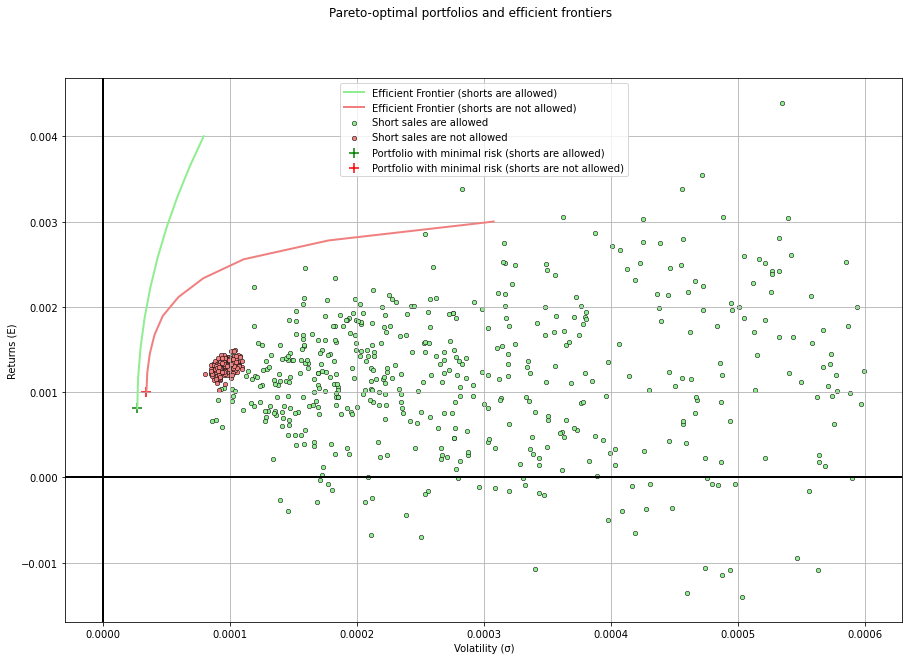

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle("Pareto-optimal portfolios and efficient frontiers")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

# random portfolios plot
ax.scatter(random_portfolios_short_std_devs, random_portfolios_short_means, marker="o", color='lightgreen',
           edgecolors= 'black', linewidth=0.5, s=20, label="Short sales are allowed")
ax.scatter(random_portfolios_no_short_std_devs, random_portfolios_no_short_means, marker="o", color='lightcoral',
           edgecolors= 'black', linewidth=0.5, s=20, label="Short sales are not allowed")

# optimal frontier plot
ax.plot(opt_volatilities_short, target_returns_short, color="lightgreen", linewidth=2, label="Efficient Frontier (shorts are allowed)")
ax.plot(opt_volatilities_no_short, target_returns_no_short, color="lightcoral", linewidth=2, label="Efficient Frontier (shorts are not allowed)") 

# min risk plot 
ax.scatter(opt_short_volatility, opt_short_return, color="g", marker="+", s=100, label="Portfolio with minimal risk (shorts are allowed)")
ax.scatter(opt_no_short_volatility, opt_no_short_return, color="r", marker="+", s=100, label="Portfolio with minimal risk (shorts are not allowed)")

# equally weighted portfolio plot
#ax.scatter(eq_w_volatility, eq_w_return, color="b", marker="X", s=100, label="Equally weighted portfolio")

# market index plot
#ax.scatter(index_volatility, index_return, color="y", marker="X", s=100, label="Market index")

ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()

На графике видно, что эффективный фронт с запрещенными короткими продажами находится ниже, чем эффективным фронт с разрешенными короткими продажами, что говорит о том, что при равных рисках доходность на эффективном фронте с разрешенными короткими продажами всегда выше. 

Оптимальные портфели тоже отличаются. При разрешенных коротких продажах оптимальный портфель имеет меньший риск и меньшую доходность, чем оный при запрещенный коротких продажах. 

### Добавим на график портфель с равными долями и индекс рынка

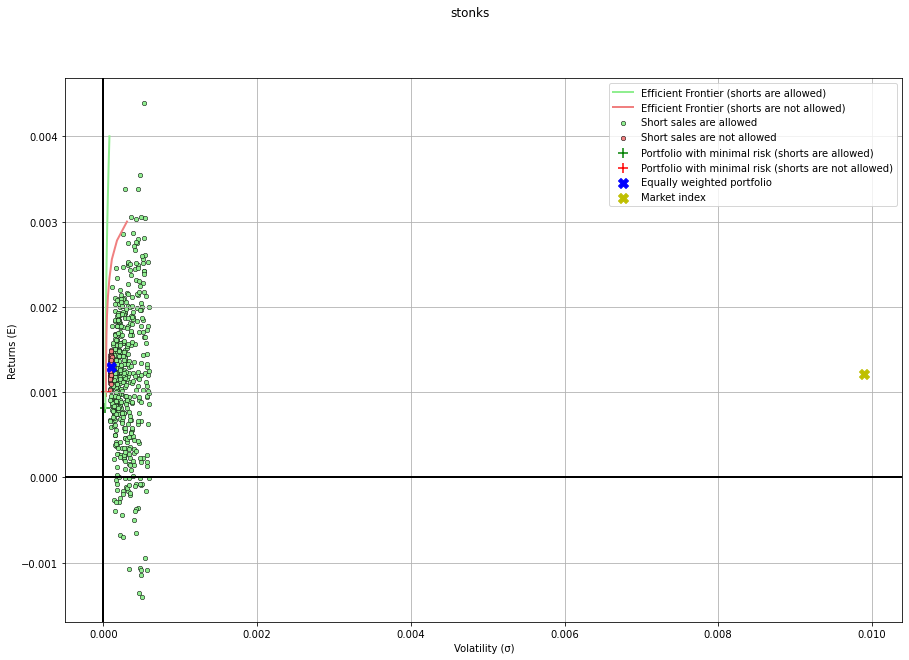

In [26]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle("stonks")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

# random portfolios plot
ax.scatter(random_portfolios_short_std_devs, random_portfolios_short_means, marker="o", color='lightgreen',
           edgecolors= 'black', linewidth=0.5, s=20, label="Short sales are allowed")
ax.scatter(random_portfolios_no_short_std_devs, random_portfolios_no_short_means, marker="o", color='lightcoral',
           edgecolors= 'black', linewidth=0.5, s=20, label="Short sales are not allowed")

# optimal frontier plot
ax.plot(opt_volatilities_short, target_returns_short, color="lightgreen", linewidth=2, label="Efficient Frontier (shorts are allowed)")
ax.plot(opt_volatilities_no_short, target_returns_no_short, color="lightcoral", linewidth=2, label="Efficient Frontier (shorts are not allowed)") 

# min risk plot 
ax.scatter(opt_short_volatility, opt_short_return, color="g", marker="+", s=100, label="Portfolio with minimal risk (shorts are allowed)")
ax.scatter(opt_no_short_volatility, opt_no_short_return, color="r", marker="+", s=100, label="Portfolio with minimal risk (shorts are not allowed)")

# equally weighted portfolio plot
ax.scatter(eq_w_volatility, eq_w_return, color="b", marker="X", s=100, label="Equally weighted portfolio")

# market index plot
ax.scatter(index_volatility, index_return, color="y", marker="X", s=100, label="Market index")

ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()

Индекс рынка находится очень далеко от фронта?

## 2. Portfolio selection problem. 

Требуется построить «хорошие» инвестиционные портфели из 10 активов вместо исходных 50 (или даже всех активов рынка). Предложите способ выбрать 10 активов (из отобранных ранее 50) для формирования портфеля. Сравните эффективные фронты всего набора (50 акций)  и выбранного набора активов (10 акций) для двух случаев
 - короткие продажи разрешены, 
 - короткие продажи запрещены.
 
 
 https://www.investopedia.com/terms/r/riskfreeasset.asp


In [41]:
# --- нужен способ отбора 10 активов!
tickers10 = tickers50[0:10]
# ---

sample_means10 = sample_means50.loc[tickers10]
sample_cov10 = sample_cov50.loc[tickers10][tickers10]
sample_cov10

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,AMGN
AAPL,0.000276,0.000128,0.000168,0.000094,0.000167,0.0,0.000178,0.000203,0.000276,0.000062
ADBE,0.000128,0.000226,0.000131,0.000105,0.000195,0.000019,0.00016,0.000137,0.000229,0.000058
ADI,0.000168,0.000131,0.000333,0.000096,0.00018,-0.00001,0.000181,0.000272,0.000312,0.000065
ADP,0.000094,0.000105,0.000096,0.000132,0.000111,0.00002,0.000113,0.000114,0.000175,0.00005
ADSK,0.000167,0.000195,0.00018,0.000111,0.000343,0.000008,0.000215,0.000209,0.000313,0.000064
AEP,0.0,0.000019,-0.00001,0.00002,0.000008,0.000071,0.00003,-0.0,-0.000006,0.000014
ALGN,0.000178,0.00016,0.000181,0.000113,0.000215,0.00003,0.000948,0.000237,0.000342,0.000105
AMAT,0.000203,0.000137,0.000272,0.000114,0.000209,-0.0,0.000237,0.000504,0.000381,0.000058
AMD,0.000276,0.000229,0.000312,0.000175,0.000313,-0.000006,0.000342,0.000381,0.001106,0.00007
AMGN,0.000062,0.000058,0.000065,0.00005,0.000064,0.000014,0.000105,0.000058,0.00007,0.000173


In [43]:
# optimal frontier for 10 stocks with short sales
x_opt_short10 = optimize_portfolio_volatility(sample_means10, sample_cov10, short_sales=True)

opt_short_return10 = calc_portfolio_return(x_opt_short10, sample_means10)
#opt_short_volatility10 = calc_portfolio_volatility(x_opt_short10, sample_cov10)

target_returns_short10 = np.linspace(opt_short_return10, 0.004, 10)
opt_volatilities_short10 = []

for target_return in target_returns_short10:
    x_opt = optimize_portfolio_volatility(sample_means10, sample_cov10, short_sales=True, custom_return=True, target_return=target_return)
    #opt_return = calc_portfolio_return(x_opt, sample_means50)
    opt_volatility = calc_portfolio_volatility(x_opt, sample_cov10)
    opt_volatilities_short10.append(opt_volatility)

Looking for a solution for 0.001196517768374832
Looking for a solution for 0.001508015794110962
Looking for a solution for 0.0018195138198470917
Looking for a solution for 0.0021310118455832214
Looking for a solution for 0.0024425098713193516
Looking for a solution for 0.0027540078970554813
Looking for a solution for 0.003065505922791611
Looking for a solution for 0.0033770039485277407
Looking for a solution for 0.0036885019742638704
Looking for a solution for 0.004


In [48]:
# optimal frontier for 10 stocks with no short sales
x_opt_no_short10 = optimize_portfolio_volatility(sample_means10, sample_cov10, short_sales=False)

opt_no_short_return10 = calc_portfolio_return(x_opt_no_short10, sample_means10)
#opt_short_volatility10 = calc_portfolio_volatility(x_opt_short10, sample_cov10)

target_returns_no_short10 = np.linspace(opt_no_short_return10, 0.0031, 10)
opt_volatilities_no_short10 = []

for target_return in target_returns_no_short10:
    x_opt = optimize_portfolio_volatility(sample_means10, sample_cov10, short_sales=False, custom_return=True, target_return=target_return)
    #opt_return = calc_portfolio_return(x_opt, sample_means50)
    opt_volatility = calc_portfolio_volatility(x_opt, sample_cov10)
    opt_volatilities_no_short10.append(opt_volatility)


Looking for a solution for 0.0012304122730466128
Looking for a solution for 0.0014381442427081003
Looking for a solution for 0.0016458762123695877
Looking for a solution for 0.0018536081820310752
Looking for a solution for 0.0020613401516925626
Looking for a solution for 0.00226907212135405
Looking for a solution for 0.0024768040910155375
Looking for a solution for 0.002684536060677025
Looking for a solution for 0.0028922680303385124
Looking for a solution for 0.0031


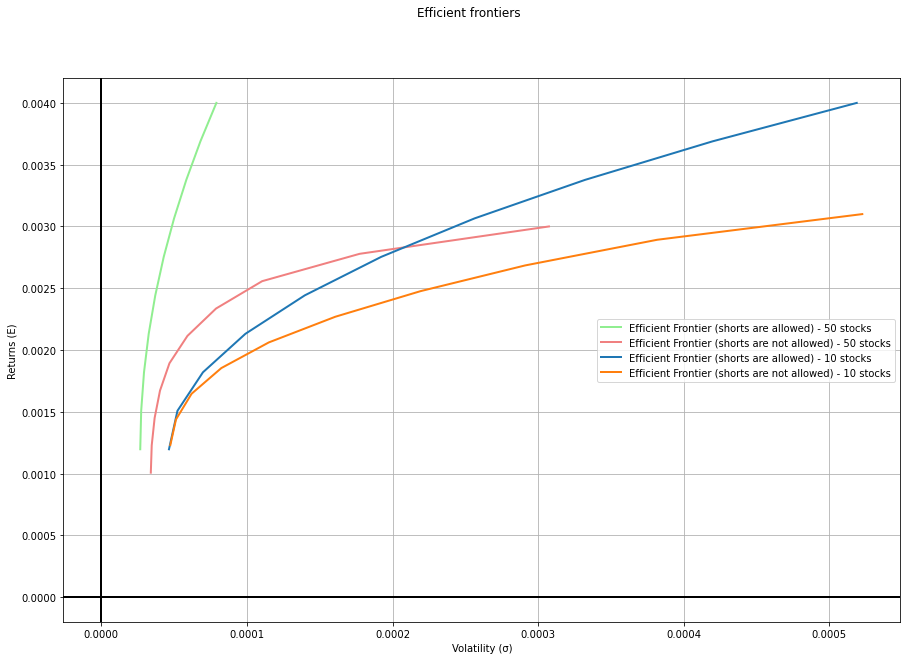

In [50]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle("Efficient frontiers")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

# optimal frontier plot
ax.plot(opt_volatilities_short, target_returns_short, color="lightgreen", linewidth=2, label="Efficient Frontier (shorts are allowed) - 50 stocks")
ax.plot(opt_volatilities_no_short, target_returns_no_short, color="lightcoral", linewidth=2, label="Efficient Frontier (shorts are not allowed) - 50 stocks") 

ax.plot(opt_volatilities_short10, target_returns_short10, color="C0", linewidth=2, label="Efficient Frontier (shorts are allowed) - 10 stocks")
ax.plot(opt_volatilities_no_short10, target_returns_no_short10, color="C1", linewidth=2, label="Efficient Frontier (shorts are not allowed) - 10 stocks") 

ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()

?